<a href="https://www.kaggle.com/code/iamamir/fake-instagram-account-detection?scriptVersionId=119266137" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

/kaggle/input/fake-account-data-dict/fake_account__data_dict.csv
/kaggle/input/social-media-test/social_media_test.csv
/kaggle/input/instagram-fake-spammer-genuine-accounts/train.csv
/kaggle/input/instagram-fake-spammer-genuine-accounts/test.csv
/kaggle/input/social-media-aim/social_media_aim.csv
/kaggle/input/social-media-train/social_media_train.csv


# Scenario
A popular social media platform for sharing photos and videos, has received complaints about fake user accounts. These fake accounts are said to have left spam comments on genuine user posts. Management has asked us to create a machine learning model that will help the platform distinguish real accounts from fake accounts. The company would then use the model to identify fake accounts so they can subsequently be deleted from the platform.

![](https://www.endnowfoundation.org/wp-content/uploads/elementor/thumbs/Detect-Fake-Profiles-on-Social-Media-p6yfct3ismgslao8tyklprwyrfd5tttfiwrd6xcjuw.jpg)


Image taken from: https://www.endnowfoundation.org/wp-content/uploads/elementor/thumbs/Detect-Fake-Profiles-on-Social-Media-p6yfct3ismgslao8tyklprwyrfd5tttfiwrd6xcjuw.jpg




# 1) Goal of this project
The goal here is to predict whether a user account is fake or not. A problem of this nature is called a binary classification problem (binary since we have two categories). We use int numbers to specify the two categories. In the 'fake' column, a 1 represents that the account in that row is fake, while a 0 indicates a real account.


# 2) Gather Data
The data is in the train.csv file. The target vector is given by the 'fake' column. Here the modules that typically is needed for reading and exploration is imported and then is read in pandas DataFrame df_train.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pdpipe as pdp
%matplotlib inline

# 4) Exploratory Data Analysis (EDA)
## Understand Data
It is necessary to familiarize with the data at the beginning so that we know later what to look for while cleaning and preparing the data.


In [7]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set max width of cell
pd.options.display.max_colwidth=300

# Suppress scientific notation
np.set_printoptions(suppress=True) 
pd.options.display.float_format = '{:.2f}'.format


# Display all columns
pd.set_option('display.max_columns', None)

# Read data
df_train = pd.read_csv("/kaggle/input/social-media-train/social_media_train.csv",index_col=[0])
print('\nModified Data Frame with new better understandable column names\n')
display(df_train.head(),df_train.info())



Modified Data Frame with new better understandable column names

<class 'pandas.core.frame.DataFrame'>
Int64Index: 576 entries, 0 to 575
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fake                   576 non-null    int64  
 1   profile_pic            576 non-null    object 
 2   ratio_numlen_username  576 non-null    float64
 3   len_fullname           576 non-null    int64  
 4   ratio_numlen_fullname  576 non-null    float64
 5   sim_name_username      576 non-null    object 
 6   len_desc               576 non-null    int64  
 7   extern_url             576 non-null    object 
 8   private                576 non-null    object 
 9   num_posts              576 non-null    int64  
 10  num_followers          576 non-null    int64  
 11  num_following          576 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 58.5+ KB


,fake,profile_pic,ratio_numlen_username,len_fullname,ratio_numlen_fullname,sim_name_username,len_desc,extern_url,private,num_posts,num_followers,num_following
0,0,Yes,0.27,0,0.00,No match,53,No,No,32,1000,955
1,0,Yes,0.00,2,0.00,Partial match,44,No,No,286,2740,533
2,0,Yes,0.10,2,0.00,Partial match,0,No,Yes,13,159,98
3,0,Yes,0.00,1,0.00,Partial match,82,No,No,679,414,651
4,0,Yes,0.00,2,0.00,No match,0,No,Yes,6,151,126


None

Each line of df_train represents a user or user account.


# 3) Dataset Description


In [8]:
data_dict = pd.read_csv('/kaggle/input/fake-account-data-dict/fake_account__data_dict.csv', index_col = 'No.')
data_dict

,Column name,Data Type,Description
No.,,,
0,'profile_pic',categorical,Whether the account has a profile picture (1) or not (0)
1,'ratio_numlen_username',numerical (float),Ratio of numeric characters in the account username to its length
2,'len_fullname',numerical (int),Number of characters in the user's full name
3,'ratio_numlen_fullname',numerical (float),Ratio of numeric characters in the user's full name to its length
4,'sim_name_username',categorical,"Whether the user's name matches their username completely (1),not at all (0)."
5,'len_desc',numerical (int),Number of characters in the account description
6,'extern_url',categorical,Whether the account description includes a URL (1) or not (2)
7,'private',categorical,Whether the user's posts are visible only to their followers (1) or to all Instagram users (2).
8,'num_posts',numerical (int),Number of posts in the user account


In [9]:
# Determine categorical and numerical features

# Numerical columns
num_cols = ['ratio_numlen_username','len_fullname','ratio_numlen_fullname',
            'len_desc','num_posts','num_followers',
              'num_following']
# Categorical columns
cat_cols = [col for col in df_train.columns.values.tolist() if col not in num_cols]
cat_cols

['fake', 'profile_pic', 'sim_name_username', 'extern_url', 'private']

In [10]:
# Check descriptive statistics
df_train[num_cols].describe()

,ratio_numlen_username,len_fullname,ratio_numlen_fullname,len_desc,num_posts,num_followers,num_following
count,576.00,576.00,576.00,576.00,576.00,576.00,576.00
mean,0.16,1.46,0.04,22.62,107.49,85307.24,508.38
std,0.21,1.05,0.13,37.70,402.03,910148.46,917.98
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,0.00,39.00,57.50
50%,0.00,1.00,0.00,0.00,9.00,150.50,229.50
75%,0.31,2.00,0.00,34.00,81.50,716.00,589.50
max,0.92,12.00,1.00,150.00,7389.00,15338538.00,7500.00


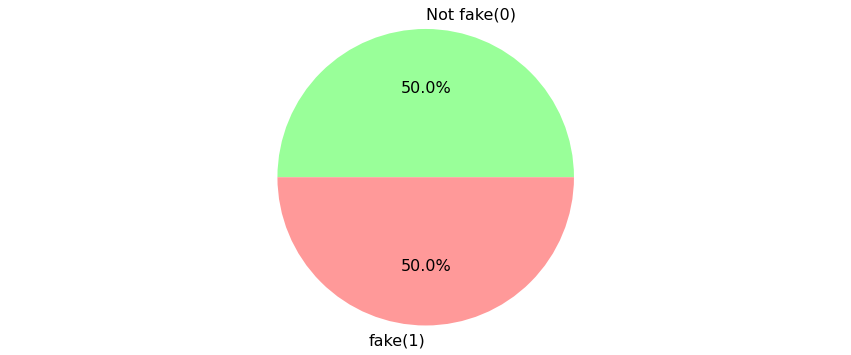

In [11]:
# Get an idea of target category: fake
plt.figure(figsize=(15,6))
fake_share = df_train["fake"].value_counts()
mylabel=["Not fake(0)","fake(1)"]
colors = ['#99ff99','#ff9999']
plt.pie(fake_share,
        labels=mylabel,autopct="%1.1f%%",colors=colors,
        textprops={'fontsize': 16})
plt.axis("equal");

Target category is strongly balanced.


In [12]:
# Check the percentage of the missing values

percent_missing = df_train.isnull().sum() * 100 / len(df_train)
missing_value_df = pd.DataFrame({'percent_missing (%)': percent_missing})
missing_value_df.sort_values('percent_missing (%)', ascending=False)


,percent_missing (%)
fake,0.00
profile_pic,0.00
ratio_numlen_username,0.00
len_fullname,0.00
ratio_numlen_fullname,0.00
sim_name_username,0.00
len_desc,0.00
extern_url,0.00
private,0.00
num_posts,0.00


In [13]:
# Correlation heatmap
# Colormap: Most negative correlations (dark-blue) to most positive correlation (dark red)
corr = df_train[num_cols].corr()
corr.style.background_gradient(cmap='coolwarm')

,ratio_numlen_username,len_fullname,ratio_numlen_fullname,len_desc,num_posts,num_followers,num_following
ratio_numlen_username,1.000000,-0.225472,0.408567,-0.321170,-0.157442,-0.062785,-0.172413
len_fullname,-0.225472,1.000000,-0.094348,0.272522,0.073350,0.033225,0.094855
ratio_numlen_fullname,0.408567,-0.094348,1.000000,-0.117521,-0.057716,-0.027035,-0.067971
len_desc,-0.321170,0.272522,-0.117521,1.000000,0.144824,0.005929,0.226561
num_posts,-0.157442,0.073350,-0.057716,0.144824,1.000000,0.321385,0.098225
num_followers,-0.062785,0.033225,-0.027035,0.005929,0.321385,1.000000,-0.011066
num_following,-0.172413,0.094855,-0.067971,0.226561,0.098225,-0.011066,1.000000


Just like linear regression, logistic regression makes a number of assumptions. For continuous data, the following are relevant:
* The features should not be strongly correlated with each other.
* There should be a linear relationship between the features and the sigmoid transformed probabilities.

As can be seen all correlation values between features relatively close to 0, rark blue (First criteria above fulfilled). Number of characters in the account description for example 'ratio_numlen_username' shows most positive and negative correlation with fake status.

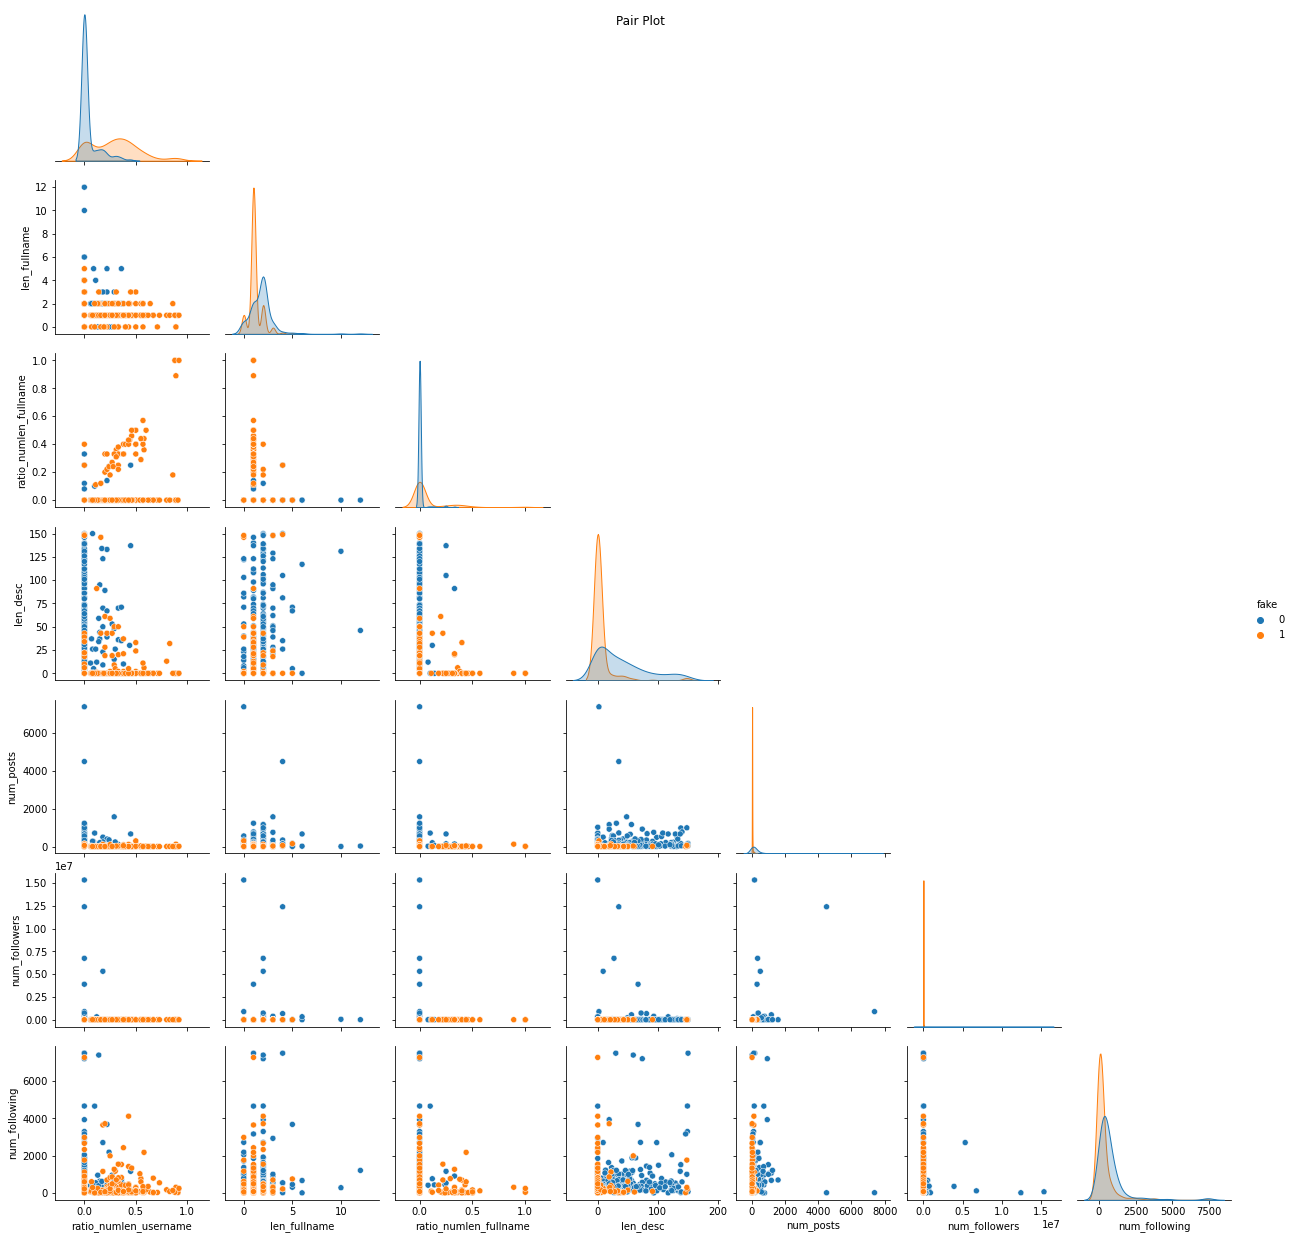

In [14]:
# Pair plot oapif numerical values with fake account information
pp_cols = []
pp_cols = num_cols + ['fake']
ax=sns.pairplot(df_train[pp_cols], hue="fake",corner=True);
ax.fig.suptitle("Pair Plot");

#### Very first finding:
* As can be seen from pair plots above, fake accounts are more spread around the mean for ratio_numlen_username, ratio of numeric characters in the account username to their length. Values of real accounts, in this case, are strongly clustered around their mean. 
* Most fake accounnts have less words of descriptions (len_desc) in their bio, as the average of description words for fake accounts is less than real accounts.
* ratio_numlen_fullname and ratio_numlen_username are correlated with eachother. Correlation matrix showes a value of +0.4085 for this correlation.
* Average number of posts and followers of fake accounts are close to zero.
 

Lets do some investigations of categorical data:

In [15]:
# Categorical data
display(df_train.loc[:, cat_cols].head())
print('----------------------')

# Unique values
for col in cat_cols:
    unique_values = df_train.loc[:, col].unique()
    print("\nColumn name: {}\nUnique values: {}".format(col, unique_values))  

,fake,profile_pic,sim_name_username,extern_url,private
0,0,Yes,No match,No,No
1,0,Yes,Partial match,No,No
2,0,Yes,Partial match,No,Yes
3,0,Yes,Partial match,No,No
4,0,Yes,No match,No,Yes


----------------------

Column name: fake
Unique values: [0 1]

Column name: profile_pic
Unique values: ['Yes' 'No']

Column name: sim_name_username
Unique values: ['No match' 'Partial match' 'Full match']

Column name: extern_url
Unique values: ['No' 'Yes']

Column name: private
Unique values: ['No' 'Yes']


In [16]:
# Define function label_encoding
def label_encoding(df):
    '''
    doc-string
    '''
    # label encoding
    dict_label_encoding = {'Yes': 1, 'No': 0}
    df.loc[:, 'profile_pic'] = df.loc[:, 'profile_pic'].replace(dict_label_encoding)
    df.loc[:, 'extern_url'] = df.loc[:, 'extern_url'].replace(dict_label_encoding)
    df.loc[:, 'private'] = df.loc[:, 'private'].replace(dict_label_encoding)

    # one-hot encoding
    onehot = pdp.OneHotEncode(["sim_name_username"], drop_first=False)
    # fit and transform on train set
    df = onehot.fit_transform(df)
    return df       

# Applay function label_encoding
df_train = label_encoding(df_train)
df_train.head()

,fake,profile_pic,ratio_numlen_username,len_fullname,ratio_numlen_fullname,len_desc,extern_url,private,num_posts,num_followers,num_following,sim_name_username_Full match,sim_name_username_No match,sim_name_username_Partial match
0,0,1,0.27,0,0.00,53,0,0,32,1000,955,0,1,0
1,0,1,0.00,2,0.00,44,0,0,286,2740,533,0,0,1
2,0,1,0.10,2,0.00,0,0,1,13,159,98,0,0,1
3,0,1,0.00,1,0.00,82,0,0,679,414,651,0,0,1
4,0,1,0.00,2,0.00,0,0,1,6,151,126,0,1,0


# The logistic regression

In this notebook, we firstly focus on Logistic Regression which is known algorithm for classification tasks. Please see [this article](https://realpython.com/logistic-regression-python/#:~:text=The%20logistic%20regression%20function%20%F0%9D%91%9D(%F0%9D%90%B1)%20is%20the%20sigmoid%20function,that%20the%20output%20is%200.) for more detail about logostic regresion.
From regularization we know that it can be helpful if a linear regression tries to minimize the slope values. For example, overfitting can be avoided.
In contrast to the logistic regression without regularization, the features must be standardized in the model with regularization! This is due to penalty parameters (l2 by default) in logistic regression: like linear regression, logistic regression with regularization makes the prediction dependent on the scaling of the features, where at 𝐿1 (Lasso) and 𝐿2 (Ridge) large coefficients are penalized more heavily. So, in order for the coefficients to be penalized equally, we need to standardize the coefficients.

## Logistic regression with and without regularization
As with linear regression and its Ridge and Lasso versions, logistic regression also allows for regularization. Please see [this article](https://www.andreaperlato.com/theorypost/ridge-and-lasso-regression/) for more details about regularisations.

we can now set up a logistic regression model By default, sklearn's logistic regression algorithm already uses regularization with the regularization parameter C=1.0. If we assign an extremely large value to C, such as a 1 followed by 42 zeros (1e42), no regularization is performed. That's what we want to achieve here first.

The algorithm needs many attempts to solve the problem. The default 100 iterations are not enough. Therefore, we should also assign a relatively large number to max_iter. This parameter sets the maximum number of iterations the solvers need to converge. 10000 (1e4) should suffice here.

In [56]:
# Import Logistic Regression model
from sklearn.linear_model import LogisticRegression

###################################################################
# a) Without regularisation

# Feature matrix and target vector
features_train = df_train.iloc[:, 1:]
target_train = df_train.loc[:, 'fake']

# Model instantiation
model_log = LogisticRegression(solver='lbfgs', max_iter=1e4, C=1e42, random_state=42)

# Model fitting
model_log.fit(features_train, target_train)

#####################################################################
# b) With regularisation

# Standardization to adjust the features
from sklearn.preprocessing import StandardScaler 

# Fit on training data and scale them
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)

# Model instantiation
model_reg = LogisticRegression(solver='lbfgs', max_iter=1e4, C=0.5, random_state=42)

# Model fitting
model_reg.fit(features_train_scaled, target_train)

LogisticRegression(C=0.5, max_iter=10000.0, random_state=42)

# Model Performance Evaluation 

We use test data from test.csv for initial classification performance:

In [57]:
# Read data
df_test = pd.read_csv("/kaggle/input/social-media-test/social_media_test.csv",index_col=[0])
df_test = label_encoding(df_test)
df_test.head()

,fake,profile_pic,ratio_numlen_username,len_fullname,ratio_numlen_fullname,len_desc,extern_url,private,num_posts,num_followers,num_following,sim_name_username_Full match,sim_name_username_No match,sim_name_username_Partial match
0,0,1,0.33,1,0.33,30,0,1,35,488.00,604,1,0,0
1,0,1,0.00,5,0.00,64,0,1,3,35.00,6,0,0,1
2,0,1,0.00,2,0.00,82,0,1,319,328.00,668,0,0,1
3,0,1,0.00,1,0.00,143,0,1,273,14890.00,7369,0,1,0
4,0,1,0.50,1,0.00,76,0,1,6,225.00,356,0,1,0


In [58]:
# Feature matrix and target vector
features_test = df_test.drop('fake',axis=1)
target_test = df_test['fake']

 # Without regularisation
# predict target values from model
target_test_pred_log = model_log.predict(features_test)

# model evaluation
from sklearn.metrics import precision_score, recall_score
precision_log = precision_score(target_test, target_test_pred_log)
recall_log = recall_score(target_test, target_test_pred_log)

# print
print('Precision of model without regularisation: ', precision_log)
print('Recall of model without regularisation: ', recall_log)

#####################################################################
# With regularisation
# features matrix and target vector
features_test_scaled = scaler.transform(features_test)

# predict target values from model
target_test_pred_reg = model_reg.predict(features_test_scaled)

# model evaluation
precision_reg = precision_score(target_test, target_test_pred_reg)
recall_reg = recall_score(target_test, target_test_pred_reg)

# print
print('Precision of model with regularisation: ', precision_reg)
print('Recall of model with regularisation: ', recall_reg)

Precision of model without regularisation:  0.8666666666666667
Recall of model without regularisation:  0.8666666666666667
Precision of model with regularisation:  0.8813559322033898
Recall of model with regularisation:  0.8666666666666667


model_logg is better at recognizing actual fake accounts as such (recall), while model_reg has more actual fake accounts among predicted fake accounts (precision). In other words, model_log's predictions can be trusted a little less than model_reg.

# Model Performance

LogisticRegression uses a threshold of 0.5 (50%) for determining the predicted categories. If we lower this threshold, there are more and more positive predictions and thus the recall increases. At the same time, however, the precision also decreases, because more and more of the predicted reference category cases are none at all.

The question here is which classification threshold suits our specific problem well? We can investigate this issue with the help of [ROC (Receiver Operating Characteristic) curve](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics). ROC curves are a nice way to see how any predictive classifier like logostic regression model can distinguish between the true positives and negatives.
![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*7NVPwda0vt4obd_Q01t9Rw.png)

The ROC curve does this by plotting sensitivity, the probability of predicting a real positive will be a positive, against 1-specificity, the probability of predicting a real negative will be a positive. 

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*b3ayb4TkvOdsNdDmJVQG1g.png)

The false positive rate is essentially a measure of how often a “false alarm” will occur — or, how often an actual negative instance will be classified as positive. 
Figure above demonstrates how some theoretical classifiers would plot on an ROC curve. The gray dotted line represents a classifier that is no better than random guessing — this will plot as a diagonal line. The purple line represents a perfect classifier — one with a true positive rate of 100% and a false positive rate of 0%. Nearly all real-world examples will fall somewhere between these two lines — not perfect, but providing more predictive power than random guessing. Typically, what we’re looking for is a classifier that maintains a high true positive rate while also having a low false positive rate — this ideal classifier would “hug” the upper left corner of Figure 1, much like the purple line in figure above. Image and text taken from: https://towardsdatascience.com/understanding-the-roc-curve-and-auc-dd4f9a192ecb

Back to our problem, how can we compare two different implemented model above? What are the false positive rates for model_log and model_reg? how the recall  and the false positive rate change with the threshold. This can be investigated via ROC curve.

The roc_curve() function from sklearn.metrics calculates the values ​​of the curve. It needs the predicted probabilities. In a classification model, we always use my_model.predict() to predict the categories. Instead, if we want to know the probability of belonging to one category or another, we should use [my_model.predict_proba()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#:~:text=%5Bsource%5D-,Probability%20estimates.,-The%20returned%20estimates).

In [33]:
# module import
from sklearn.metrics import roc_curve

# calculate roc curve values
def roc_curve_values(model,features,target):
    '''
    doc_string
    '''
    # calculate probability
    target_test_pred_proba = model.predict_proba(features) 
    
    # calculate roc curve values
    false_positive_rate, recall, threshold = roc_curve(target,
                                                       target_test_pred_proba[:,1],
                                                       drop_intermediate=False)
    
    return false_positive_rate, recall, target_test_pred_proba    

In [34]:
# Apply function roc_curve_values for model without regularization
false_positive_rate_log, recall_log, target_test_pred_proba_log  = roc_curve_values(model_log,features_test,target_test)

In [35]:
# Apply function roc_curve_values for model with regularization
false_positive_rate_reg, recall_reg, target_test_pred_proba_reg  = roc_curve_values(model_reg,features_test,target_test)

In [28]:
def roc_curve_plot(false_positive_rate,recall,label):
    '''
    
    '''
    plt.style.use('fivethirtyeight')
    fig,ax=plt.subplots()
    
    # Reference lines
    # Blue diagonal
    ax.plot([0, 1], ls = "--", label='random model')  
    # Grey vertical
    ax.plot([0, 0], [1, 0], c=".7", ls='--', label='ideal model') 
    # Grey horizontal
    ax.plot([1, 1], c=".7", ls='--')  
    
    # ROC curve
    ax.plot(false_positive_rate,recall, label = label)
    
    # labels
    ax.set_title("Receiver Operating Characteristic")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("Recall")
    ax.legend()

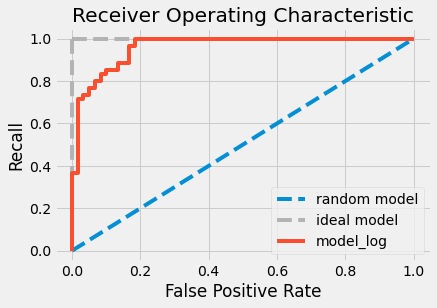

In [29]:
roc_curve_plot(false_positive_rate_log,recall_log,'model_log')

The red curve is the outcome from the model without regularization. From the recall of around 42% and from a false positive rate of approx. 19%, it hardly deviates from the ideal. So the model appears generally very good as it follows the gray ideal rather than the blue rate line. But it's not perfect.

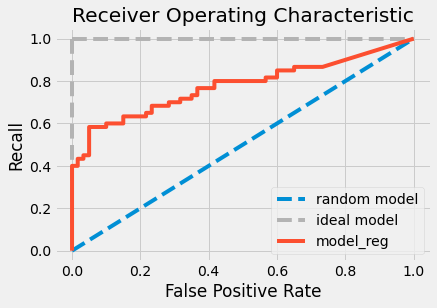

In [31]:
roc_curve_plot(false_positive_rate_reg,recall_reg,'model_reg')

The ROC curve of the model with regularization (model_reg) deviates a little more from the ideal gray dashed line of the model without regularization (model_log). This suggests that the logistic regression model with regularization is slightly worse in accuracy than the non-regularized model.

# ROC AUC measure

To create a quantifiable model performance measure from the visual impression we just used, use the area under the curve. Hence the name of the model quality measure: receiver operator characteristic area under the curve (ROC-AUC).

The [ROC AUC score ](https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/#:~:text=The%20ROC%20AUC%20score%20tells,and%20the%20Negative%20class%20points.)tells us how efficient the model is. The higher the AUC, the better the model’s performance at distinguishing between the positive and negative classes. An AUC score of 1 means the classifier can perfectly distinguish between all the Positive and the Negative class points. An AUC value of 0 shows that the classifier predicts all Negatives as Positives and vice versa.
![](https://miro.medium.com/v2/resize:fit:828/format:webp/1*PU3_4LheadpGcpl6daO1mA.png)

Image source: https://medium.com/the-owl/evaluation-metrics-part-3-47c315e07222

In [37]:
# Import roc_auc_score
from sklearn.metrics import roc_auc_score
print('roc_auc_score for model without regularization', roc_auc_score(target_test, target_test_pred_proba_log[:, 1]))
print('##########################################################')
print('roc_auc_score for model with regularization', roc_auc_score(target_test, target_test_pred_proba_reg[:, 1]))

roc_auc_score for model without regularization 0.9608333333333333
##########################################################
roc_auc_score for model with regularization 0.7763888888888889


Comparing the score of the model without regularization 96%, to model with regularization 77%, it confirms our visual impression above: the model with regularization follows the ideal less than the model without regularization. The regularization has thus harmed the model quality rather than helped it. Regardless of the chosen decision thresholds, we can conclude that we have overfitted our model!

# Find the best logistic regression model with grid search and ROC-AUC

We can now combine the accumulated knowledge. We will use the ROC AUC measure to find the best logistic regression model and then use it to predict the fake status of the social media accounts.
Thanks to the GridSearchCV the optimal hyperparameters of models can be found automatically. We can now turn to the pipeline containing the steps from data processing and feature engineering to prediction.

Before we can start the grid search, we still have to define the grid of hyperparameters that is to be searched:
* Penalty: whether the regularization is like Ridge ('l2') or like LASSO ('l1')
* C: Regularization weakness - Inverse of regularization strength

Since we want to try both regularizations of ridge regression and lasso regression, we cannot use 'lbfgs' as before. Only the 'saga' setting supports both types of regularization. Please see [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#:~:text=solver%7B%E2%80%98lbfgs%E2%80%99%2C%20%E2%80%98liblinear%E2%80%99%2C%20%E2%80%98newton%2Dcg%E2%80%99%2C%20%E2%80%98newton%2Dcholesky%E2%80%99%2C%20%E2%80%98sag%E2%80%99%2C%20%E2%80%98saga%E2%80%99%7D%2C%20default%3D%E2%80%99lbfgs%E2%80%99) for more details.

In order for the algorithm to find a good result, it has to make a relatively large number of attempts. Therefore, max_iter should be increased from the default of 100 iterations. 10000 iterations (1e4) seem to be enough.

In [68]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline_log = Pipeline([('scaler',StandardScaler()),('classifier',LogisticRegression(solver='saga',
                                                                  max_iter=1e4, 
                                                                  random_state=42))])


C_values = np.geomspace(start=0.001, stop=1000, num=14)

# Determine search space of hyperparameters:
search_space_grid = [{'classifier__penalty': ['l1', 'l2'],
                      'classifier__C': C_values}]

# Apply Grid Search
model_grid = GridSearchCV(estimator=pipeline_log,
                          param_grid=search_space_grid,
                          scoring='roc_auc',
                          cv=5,
                          n_jobs=-1)

# Model fitting
model_grid.fit(features_train, target_train)

# Print best estimater and score
print(model_grid.best_estimator_)
print(model_grid.best_params_)
print(model_grid.best_score_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=4.923882631706742, max_iter=10000.0,
                                    random_state=42, solver='saga'))])
{'classifier__C': 4.923882631706742, 'classifier__penalty': 'l2'}
0.9657175042242944


**The logistic regression model that leads to this value uses a regularization like the ridge regression (penalty='l2') and regularizes a little less than the standard model (C=4.92).**

# Model evaluation with test data

It is best to check whether the extraordinarily good model quality according to cross-validation is also achieved with the test data.

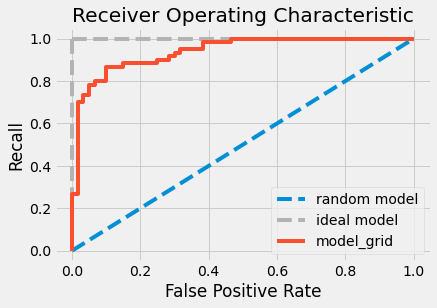

In [72]:
# Apply function roc_curve_values for model with regularization
false_positive_rate_grid, recall_grid, target_test_pred_proba  = roc_curve_values(model_grid,features_test,target_test)
roc_curve_plot(false_positive_rate_grid,recall_grid,'model_grid')

In [73]:
target_test_pred_proba = model_grid.predict_proba(features_test)
roc_auc_score(target_test, target_test_pred_proba[:, 1])

0.9391666666666667

This value (ROC-AUC measure of 93.9%) is very good, but unfortunately slightly lower than the model figure of merit calculated using the validation data during the grid search. A discrepancy between model performance on test data and validation data is common.

# Prediction


In [79]:
# Read data
df_aim = pd.read_csv("/kaggle/input/social-media-aim/social_media_aim.csv",index_col=[0])
df_aim = label_encoding(df_aim)
features_aim = df_aim.copy()
df_aim.loc[:, 'fake_pred_proba'] = model_grid.predict_proba(features_aim)[:, 1]
df_aim.loc[:, 'fake_pred'] = model_grid.predict(features_aim)
df_aim

,profile_pic,ratio_numlen_username,len_fullname,ratio_numlen_fullname,len_desc,extern_url,private,num_posts,num_followers,num_following,sim_name_username_Full match,sim_name_username_No match,sim_name_username_Partial match,fake_pred_proba,fake_pred
0,1,0.33,1,0.33,30,0,1,35,488.00,604,1,0,0,1.00,1
1,1,0.22,2,0.00,63,0,1,46,464.00,367,0,0,1,0.22,0
2,0,0.00,2,0.00,0,0,0,0,22.00,82,0,1,0,0.98,1
3,1,0.33,1,0.00,0,0,0,81,75.00,55,0,0,1,0.63,1
4,1,0.00,1,0.00,137,1,0,1065,155537.00,1395,0,1,0,0.00,0
5,1,0.27,1,0.00,0,0,0,0,45.00,64,0,0,1,0.71,1
6,0,0.44,1,0.44,112,0,0,4,415.00,1445,1,0,0,1.00,1


In [80]:
There are two Pictaglam accounts where the model is absolutely sure about the categorization. The predicted fake probability is either exactly 1.0 or 0.0.

SyntaxError: invalid syntax (4206371513.py, line 1)